## Demo Notebook: Behavior clustering

In [1]:
import sys
sys.path.append('/Users/annateruel/socialhierarchy/code/')
from behavioral_clustering import load_features, sample_frames, run_umap, train_embedding_model, plot_umap_embedding, map_density, map_feature_by_cluster, normalize_features
import pandas as pd

/Users/annateruel/miniconda3/envs/umap/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sp_frames = sample_frames(directory='/Users/annateruel/Desktop/features',
                          file_format='csv',
                          frames_total = 100000 
)

sp_frames_n = normalize_features(sp_frames)


In [3]:
embedding = run_umap(sp_frames_n, min_dist=0.5, n_components=2)

Running UMAP embedding...


/Users/annateruel/miniconda3/envs/umap/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP completed in 121.93 seconds.
UMAP embedding shape: (99968, 2)


In [ ]:
train_embedding_model(embedding, sp_frames, save_model=True,
                      save_path='/Users/annateruel/Desktop/embedding_model.h5')

In [ ]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import pandas as pd

# Re-train or load your model
mlp = train_embedding_model(sp_frames, embedding, save_path='/Users/annateruel/Desktop/embedding_model.h5')

# Compute permutation importance
result = permutation_importance(mlp, sp_frames, embedding, n_repeats=1000, random_state=42, scoring='r2')

# Plot mean importance for each feature
importances = pd.Series(result.importances_mean, index=[f'feat_{i}' for i in range(sp_frames.shape[1])])
importances.sort_values(ascending=False).plot(kind='bar', figsize=(14, 4), title='Permutation Importance (MLP -> UMAP)')
plt.tight_layout()
plt.show()

In [ ]:
zero_importance_features = importances[importances < 0.0001]
print("Features with zero importance:")
print(zero_importance_features)

UMAP embedding plot saved to /Users/annateruel/Desktop/umap_embedding.png


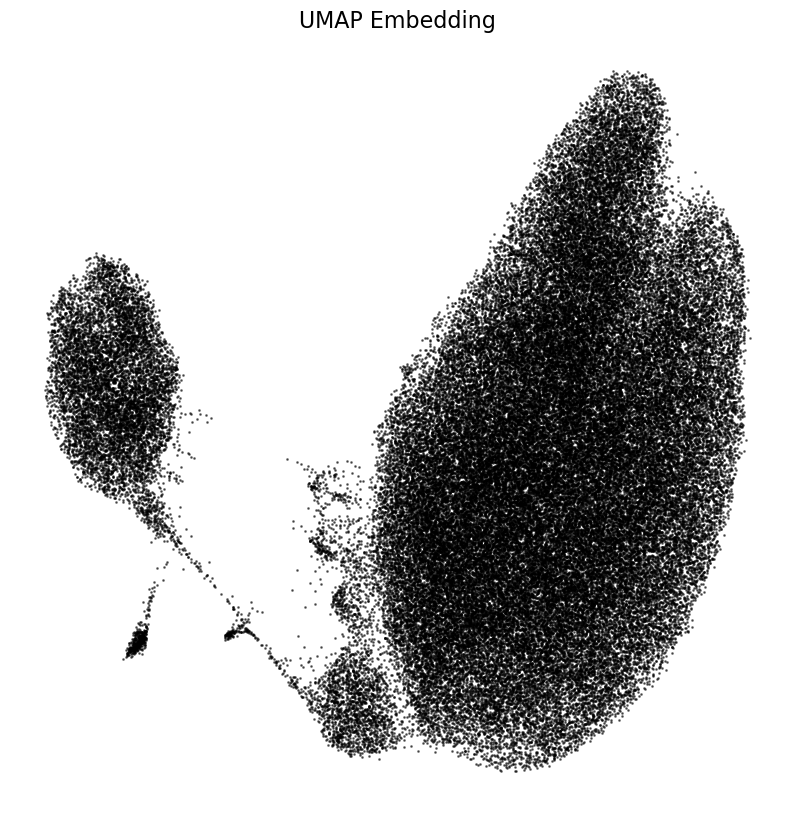

In [4]:
plot_umap_embedding(embedding, save=True, save_dir= '/Users/annateruel/Desktop', format='png')

Computing density map...
Plot saved to /Users/annateruel/Desktop/umap_heatmap.svg


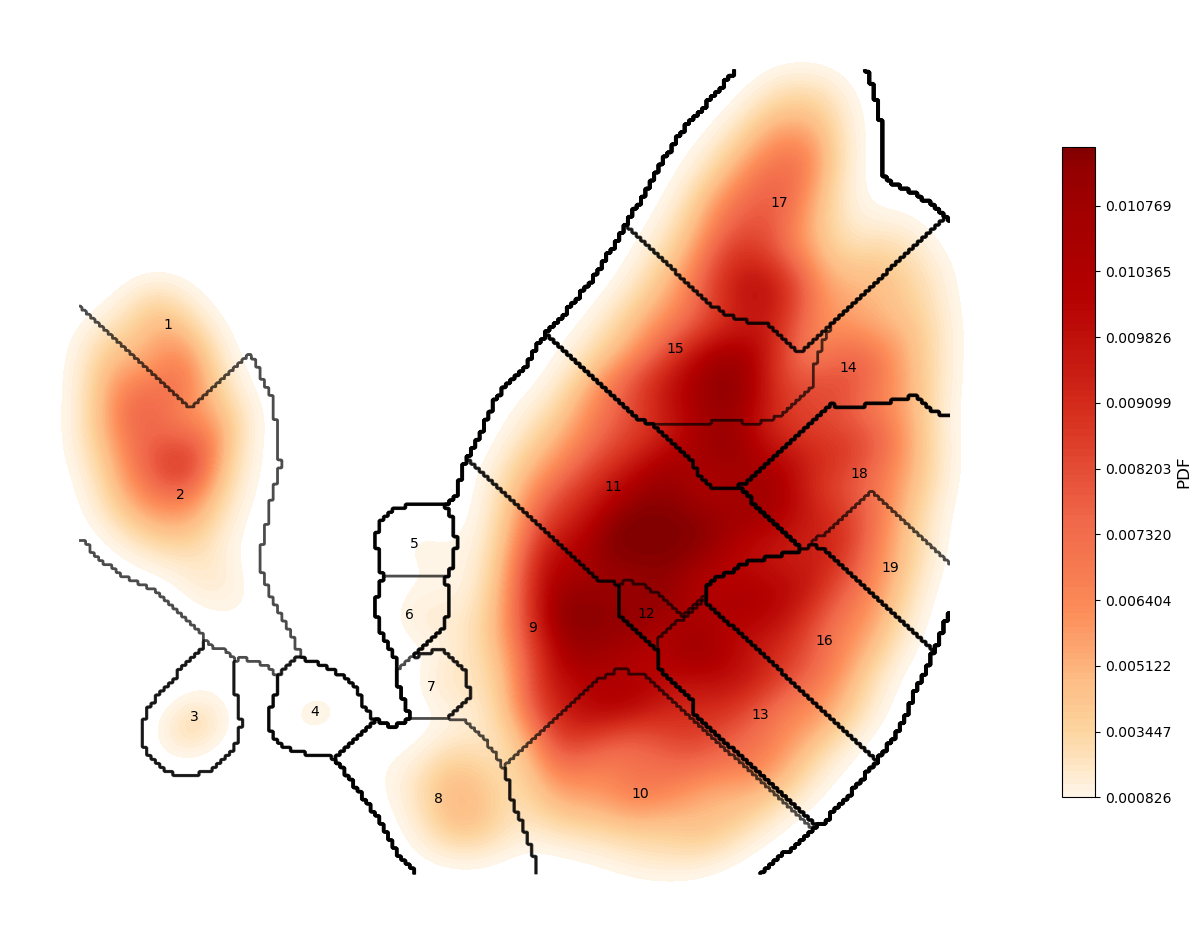

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-4.76951742, -4.65818896, -4.54686049, -4.43553202, -4.32420356,
        -4.21287509, -4.10154663, -3.99021816, -3.87888969, -3.76756123,
        -3.65623276, -3.5449043 , -3.43357583, -3.32224736, -3.2109189 ,
        -3.09959043, -2.98826197, -2.8769335 , -2.76560503, -2.65427657,
        -2.5429481 , -2.43161964, -2.32029117, -2.20896271, -2.09763424,
        -1.98630577, -1.87497731, -1.76364884, -1.65232038, -1.54099191,
        -1.42966344, -1.31833498, -1.20700651, -1.09567805, -0.9

In [6]:
map_density(embedding, 
            sigma= 4, 
            percentile=40, 
            cmap='OrRd', 
            save=True, 
            save_dir='/Users/annateruel/Desktop', 
            format='svg')

In [13]:
sp_frames[:, 8]

array([411.54763902, 401.3298618 , 391.31284702, ..., 368.12664388,
       356.03800197, 348.66081724])

In [ ]:
def map_feature_by_cluster(embedding, 
                           variable, 
                           labeled_map, 
                           xe, 
                           ye,
                           agg_func=np.mean, 
                           cmap='plasma',
                           save=False, 
                           save_dir=None, 
                           format='svg'):
    """
    Plot each cluster as an individual vector shape (Polygon), colored by an aggregated behavioral feature.
    Suitable for SVG export with editable elements.

    Args:
        embedding (np.ndarray): 2D UMAP coordinates (n x 2).
        variable (np.ndarray): Variable per point (same n).
        labeled_map (np.ndarray): 2D map of cluster labels.
        xe, ye (np.ndarray): Edges used to map embedding to labeled_map.
        agg_func (function): Function to aggregate values per cluster.
        cmap (str): Colormap name.
        save (bool): Whether to save SVG.
        save_dir (str): Where to save.
        format (str): File format, e.g. 'svg'.

    Returns:
        fig, ax
    """
    # assign points to clusters
    xi = np.digitize(embedding[:, 0], xe) - 1
    yi = np.digitize(embedding[:, 1], ye) - 1
    valid = (
        (xi >= 0) & (xi < labeled_map.shape[0]) &
        (yi >= 0) & (yi < labeled_map.shape[1])
    )
    labels = labeled_map[xi[valid], yi[valid]]
    variable_valid = variable[valid]

    cluster_values = {}
    for label, val in zip(labels, variable_valid):
        if label > 0:
            cluster_values.setdefault(label, []).append(val)
    label_to_val = {k: agg_func(v) for k, v in cluster_values.items()}
    all_labels = sorted(label_to_val.keys())
    all_vals = np.array([label_to_val[k] for k in all_labels])
    norm = plt.Normalize(vmin=np.min(all_vals), vmax=np.max(all_vals))
    cmap_obj = cm.get_cmap(cmap)

    fig, ax = plt.subplots(figsize=(14, 12))
    patches = []
    colors = []

    for label in all_labels:
        mask = labeled_map == label
        if np.sum(mask) < 20:
            continue
        contours = measure.find_contours(mask.astype(float), 0.5)
        color = cmap_obj(norm(label_to_val[label]))

        for contour in contours:
            contour = np.array(contour)
            x_contour = xe[0] + (xe[-1] - xe[0]) * contour[:, 0] / labeled_map.shape[0]
            y_contour = ye[0] + (ye[-1] - ye[0]) * contour[:, 1] / labeled_map.shape[1]
            poly = Polygon(np.stack([x_contour, y_contour], axis=1), closed=True)
            patches.append(poly)
            colors.append(color)

    p = PatchCollection(patches, facecolors=colors, edgecolors='black', linewidths=1)
    ax.add_collection(p)

    for label in all_labels:
        mask = labeled_map == label
        com = center_of_mass(mask)
        cx = xe[0] + (xe[-1] - xe[0]) * com[0] / labeled_map.shape[0]
        cy = ye[0] + (ye[-1] - ye[0]) * com[1] / labeled_map.shape[1]
        ax.text(cx, cy, str(int(label)), color="black", fontsize=10, ha="center", va="center")

    sm = cm.ScalarMappable(norm=norm, cmap=cmap_obj)
    cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.04)
    cbar.ax.tick_params(labelsize=10)

    ax.set_xlim(xe[0], xe[-1])
    ax.set_ylim(ye[0], ye[-1])
    ax.set_aspect('equal')
    ax.axis('off')

    if save and save_dir:
        path = f"{save_dir}/clusters_features.{format}"
        plt.savefig(path, dpi=300, format=format, pad_inches=0.5)
        print(f"Saved SVG to: {path}")

    plt.show()
    return fig, ax

In [23]:
import numpy as np
import pandas as pd
import os
import time
import umap #type: ignore
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, label
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from scipy.ndimage import center_of_mass
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy.ma as ma
import matplotlib.cm as cm
import seaborn as sns
from scipy.ndimage import zoom, center_of_mass
from skimage import measure
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import joblib
from sklearn.preprocessing import StandardScaler

def map_feature_by_cluster(embedding, 
                           variable, 
                           labeled_map, 
                           xe, 
                           ye,
                           agg_func=np.mean, 
                           cmap='plasma',
                           save=False, 
                           save_dir=None, 
                           format='svg'):
    """
    Plot each cluster as an individual vector shape (Polygon), colored by an aggregated behavioral feature.
    Suitable for SVG export with editable elements.

    Args:
        embedding (np.ndarray): 2D UMAP coordinates (n x 2).
        variable (np.ndarray): Variable per point (same n).
        labeled_map (np.ndarray): 2D map of cluster labels.
        xe, ye (np.ndarray): Edges used to map embedding to labeled_map.
        agg_func (function): Function to aggregate values per cluster.
        cmap (str): Colormap name.
        save (bool): Whether to save SVG.
        save_dir (str): Where to save.
        format (str): File format, e.g. 'svg'.

    Returns:
        fig, ax
    """
    # assign points to clusters
    xi = np.digitize(embedding[:, 0], xe) - 1
    yi = np.digitize(embedding[:, 1], ye) - 1
    valid = (
        (xi >= 0) & (xi < labeled_map.shape[0]) &
        (yi >= 0) & (yi < labeled_map.shape[1])
    )
    labels = labeled_map[xi[valid], yi[valid]]
    variable_valid = variable[valid]

    cluster_values = {}
    for label, val in zip(labels, variable_valid):
        if label > 0:
            cluster_values.setdefault(label, []).append(val)
    label_to_val = {k: agg_func(v) for k, v in cluster_values.items()}
    all_labels = sorted(label_to_val.keys())
    all_vals = np.array([label_to_val[k] for k in all_labels])
    norm = plt.Normalize(vmin=np.min(all_vals), vmax=np.max(all_vals))
    cmap_obj = cm.get_cmap(cmap)

    fig, ax = plt.subplots(figsize=(20, 10))
    patches = []
    colors = []

    for label in all_labels:
        mask = labeled_map == label
        if np.sum(mask) < 20:
            continue
        contours = measure.find_contours(mask.astype(float), 0.5)
        color = cmap_obj(norm(label_to_val[label]))

        for contour in contours:
            contour = np.array(contour)
            x_contour = xe[0] + (xe[-1] - xe[0]) * contour[:, 0] / labeled_map.shape[0]
            y_contour = ye[0] + (ye[-1] - ye[0]) * contour[:, 1] / labeled_map.shape[1]
            poly = Polygon(np.stack([x_contour, y_contour], axis=1), closed=True)
            patches.append(poly)
            colors.append(color)

    p = PatchCollection(patches, facecolors=colors, edgecolors='black', linewidths=1)
    ax.add_collection(p)

    for label in all_labels:
        mask = labeled_map == label
        com = center_of_mass(mask)
        cx = xe[0] + (xe[-1] - xe[0]) * com[0] / labeled_map.shape[0]
        cy = ye[0] + (ye[-1] - ye[0]) * com[1] / labeled_map.shape[1]
        ax.text(cx, cy, str(int(label)), color="black", fontsize=10, ha="center", va="center")

    sm = cm.ScalarMappable(norm=norm, cmap=cmap_obj)
    cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.04)
    cbar.ax.tick_params(labelsize=10)

    ax.set_xlim(xe[0], xe[-1])
    ax.set_ylim(ye[0], ye[-1])
    ax.set_aspect('equal')
    ax.axis('off')

    if save and save_dir:
        path = f"{save_dir}/clusters_features.{format}"
        plt.savefig(path, dpi=300, format=format, pad_inches=0.5)
        print(f"Saved SVG to: {path}")

    plt.show()
    return fig, ax

Computing density map...
Saved SVG to: /Users/annateruel/Desktop/clusters_features.svg


/var/folders/q4/d9bmvghd77x_l961kcngf8_c0000gn/T/ipykernel_75650/1626151858.py:70: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_obj = cm.get_cmap(cmap)


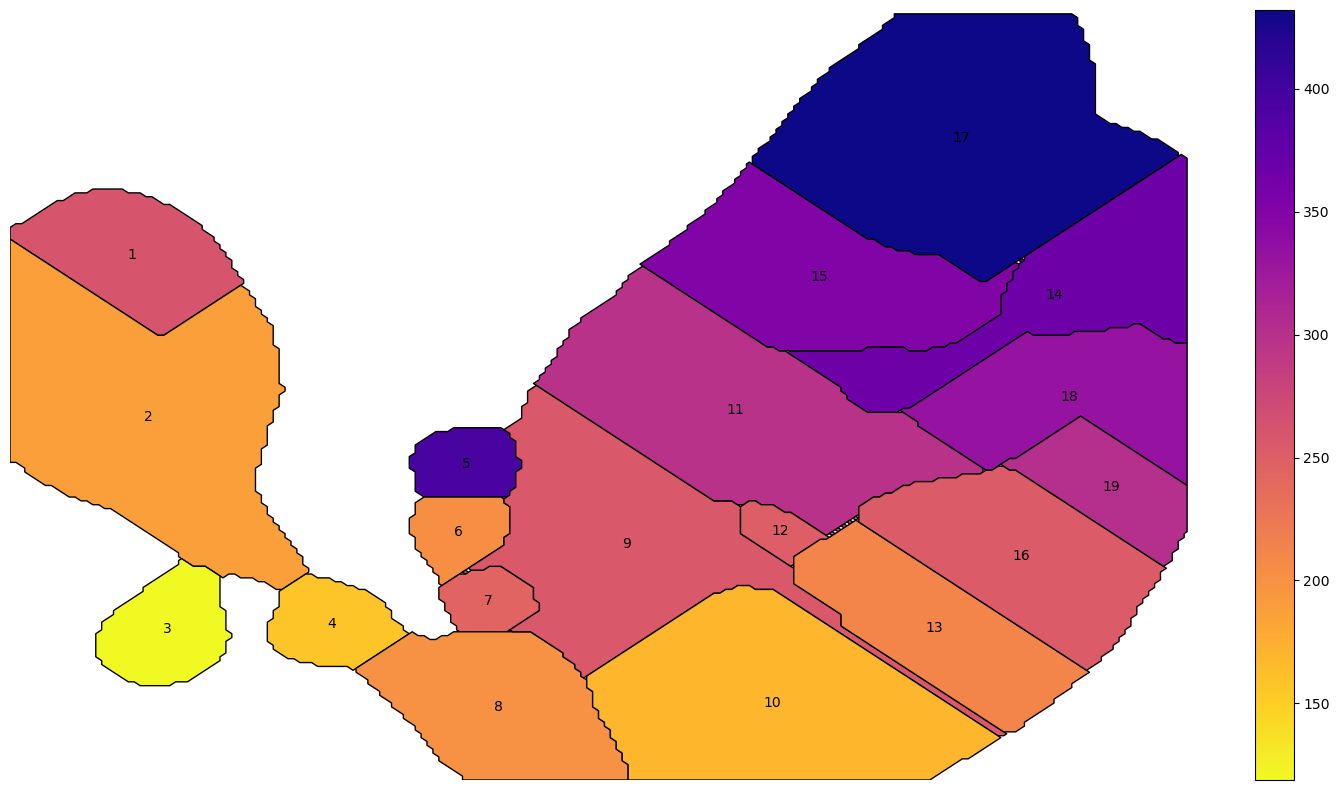

(<Figure size 2000x1000 with 2 Axes>, <Axes: >)

In [24]:
labeled_map, density_map, xe, ye = map_density(
    embedding,
    sigma=4,
    percentile=40,
    plot=False  # Set to False to avoid saving the density map
)
variable = sp_frames[:, 8]
map_feature_by_cluster(
    embedding=embedding,
    variable=variable,
    labeled_map=labeled_map,
    xe=xe,
    ye=ye,
    cmap='plasma_r',
    save=True,
    save_dir='/Users/annateruel/Desktop',
    format='svg'
)

##### TESTING CODE


In [ ]:
def hierarchical_clustering(embedding, labeled_map, xe, ye, method='ward', plot=True):
    """
    Perform hierarchical clustering on behavior clusters and optionally plot a dendrogram.

    Args:
        embedding (np.ndarray): UMAP 2D embedding (n_frames x 2).
        labeled_map (np.ndarray): Watershed cluster map from density-based clustering.
        xe (np.ndarray): x-axis bin edges from histogram2d.
        ye (np.ndarray): y-axis bin edges from histogram2d.
        method (str): Linkage method for hierarchical clustering (default 'ward').
        plot (bool): Whether to plot the dendrogram.

    Returns:
        Z (np.ndarray): The linkage matrix used to construct the dendrogram.
    """
    x_idx = np.digitize(embedding[:, 0], xe) - 1
    y_idx = np.digitize(embedding[:, 1], ye) - 1

    valid = (
        (x_idx >= 0) & (x_idx < labeled_map.shape[0]) &
        (y_idx >= 0) & (y_idx < labeled_map.shape[1])
    )
    x_idx = x_idx[valid]
    y_idx = y_idx[valid]
    embedding_valid = embedding[valid]

    cluster_labels = labeled_map[x_idx, y_idx]

    valid_points = ~np.isnan(cluster_labels) & (cluster_labels > 0)
    labels = cluster_labels[valid_points].astype(int)
    embedding_valid = embedding_valid[valid_points]
    unique_labels = np.unique(labels)
    centroids = np.array([
        embedding_valid[labels == lbl].mean(axis=0)
        for lbl in unique_labels
    ])

    Z = linkage(centroids, method=method)

    if plot:
        plt.figure(figsize=(20, 15))
        dendrogram(Z, labels=unique_labels)
        plt.title("Hierarchical Clustering of Behavioral Clusters")
        plt.xlabel("Cluster")
        plt.ylabel("Distance")
        plt.tight_layout()
        plt.show()

    return Z,  cluster_labels

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from scipy.stats import binom_test
from matplotlib import gridspec

def compute_transition_matrix(cluster_labels, n_clusters):
    cluster_labels = cluster_labels.astype(int)
    transition_matrix = np.zeros((n_clusters, n_clusters))

    for (i, j) in zip(cluster_labels[:-1], cluster_labels[1:]):
        if i > 0 and j > 0:
            transition_matrix[i - 1, j - 1] += 1

    row_sums = transition_matrix.sum(axis=1, keepdims=True)
    transition_matrix = np.divide(
        transition_matrix,
        row_sums,
        where=row_sums != 0
    )
    return transition_matrix

def plot_transition_matrix_with_dendrogram(cluster_labels, n_clusters, method='ward', annotate_significance=True, alpha=0.05):
    T = compute_transition_matrix(cluster_labels, n_clusters)

    # Hierarchical clustering on rows
    linkage_matrix = linkage(T, method=method)
    order = leaves_list(linkage_matrix)
    T_sorted = T[order, :][:, order]

    # Bootstrap significance test
    if annotate_significance:
        n_per_row = np.sum(T * (T > 0), axis=1, keepdims=True)
        p_values = np.ones_like(T)
        for i in range(n_clusters):
            for j in range(n_clusters):
                count = T[i, j] * n_per_row[i]
                if n_per_row[i] > 0:
                    p_values[i, j] = binom_test(count, n_per_row[i], 1/n_clusters, alternative='greater')
        sig_mask = p_values < alpha
        T_display = np.where(sig_mask, T_sorted, np.nan)
    else:
        T_display = T_sorted

    # Layout with dendrogram
    fig = plt.figure(figsize=(12, 10))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 5], wspace=0.05)

    # Dendrogram
    ax_dendro = plt.subplot(gs[0])
    dendrogram(linkage_matrix, orientation='left', labels=None, no_labels=True, ax=ax_dendro, color_threshold=0)
    ax_dendro.invert_yaxis()
    ax_dendro.axis('off')

    # Heatmap
    ax = plt.subplot(gs[1])
    sns.heatmap(
        T_display,
        cmap='OrRd',
        xticklabels=order + 1,
        yticklabels=order + 1,
        cbar_kws={"label": "P(start → exit)"},
        square=True,
        annot=False,
        ax=ax,
        mask=np.isnan(T_display)
    )

    # Add significance markers
    if annotate_significance:
        for i in range(n_clusters):
            for j in range(n_clusters):
                if sig_mask[order[i], order[j]]:
                    ax.text(j + 0.5, i + 0.5, '*', color='white', ha='center', va='center', fontsize=10)

    ax.set_title("Behavioral Transition Structure")
    ax.set_xlabel("exit behavior")
    ax.set_ylabel("start behavior")
    plt.tight_layout()
    plt.show()

    return T, order, linkage_matrix

In [ ]:
labeled_map, density_map, xe, ye = map_density(
    embedding, bins=200, sigma=3.5, percentile=30, plot=False
)

In [ ]:
def clean_cluster_labels(cluster_labels):
    """
    Clean cluster labels by removing NaNs and background (label ≤ 0),
    and converting to integer array for valid points only.
    """
    mask = ~np.isnan(cluster_labels) & (cluster_labels > 0)
    return cluster_labels[mask].astype(int)

In [ ]:
Z, cluster_labels = hierarchical_clustering(embedding, labeled_map, xe, ye)
clean_labels = clean_cluster_labels(cluster_labels)

# Use max based on clean labels, not the original
n_clusters = clean_labels.max()

T, order, Z = plot_transition_matrix_with_dendrogram(clean_labels, n_clusters=n_clusters)